# Imports

In [1]:
!apt-get install -y -qq tesseract-ocr-deu # needed for Tesseract in receipt_data_extraction
!pip install -q ultralytics

Selecting previously unselected package tesseract-ocr-deu.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-deu_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-deu (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-deu (1:4.00~git30-7274cfa-1.1) ...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [2]:
import sys
sys.path.append('/kaggle/input/receipt-recognition-utils')
from image_provider import get_raw_receipt, get_preprocessed_receipt
from receipt_data_extraction import ocr_extract_data
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
yolo_model_path = '/kaggle/input/receipt-recognition-utils/yolo_best.pt'
image_path = "receipt.jpg"
bbox_column = 'bbox price'

In [4]:
yolo_model = YOLO(yolo_model_path)

# Functions

In [5]:
def show_yolo_results(results):
    for r in results:
        boxes = r.boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            conf = box.conf[0]
            cls = int(box.cls[0])
            print(f"Detected checkmark: class={cls}, conf={conf:.2f}, bbox=({x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f})")
    
def show_checkmark_boxes(image_path, yolo_results, color=(0, 0, 255), thickness=2):
    img = cv2.imread(image_path)
    for r in yolo_results:
        for box in r.boxes:
            x1, y1, x2, y2 = [int(coord) for coord in box.xyxy[0]]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
            label = f'{box.conf[0]:.2f}'
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def match_checkmarks_to_items(df, yolo_results, bbox_column='bbox price'):
    checkmarks = []
    for r in yolo_results:
        for box in r.boxes:
            x1, y1, x2, y2 = [float(v) for v in box.xyxy[0]]
            checkmarks.append([x1, y1, x2, y2])

    marks = []
    for idx, row in df.iterrows():
        bbox = row.get(bbox_column)
        if bbox is None or (isinstance(bbox, float) and np.isnan(bbox)) or (isinstance(bbox, list) and len(bbox) != 4):
            marks.append(False)
            continue
        x1, y1, x2, y2 = [float(v) for v in bbox]
        found = False
        for bx1, by1, bx2, by2 in checkmarks:
            center_chk_y = (by1 + by2) / 2
            if y1 <= center_chk_y <= y2:
                found = True
                break
        marks.append(found)
    df['is_marked'] = marks
    return df

In [6]:
def process_receipt(receipt_url, sum_full, sum_final, debug):
    get_raw_receipt(receipt_url, image_path, show=debug)
    success, df = ocr_extract_data(image_path, sum_full, debug)
    if not success:
        print("Raw image use failed, trying preprcessed")
        get_preprocessed_receipt(receipt_url, image_path, show=debug)
        success, df = ocr_extract_data(image_path, sum_full, debug)

    if not success:
        print(f"Failed to extract data from receipt: {receipt_url}")
        return

    print(f"Data successfully extracted")
    
    yolo_results = yolo_model.predict(image_path)
    if debug:
        show_yolo_results(yolo_results)
        show_checkmark_boxes(image_path, yolo_results)

    df = match_checkmarks_to_items(df, yolo_results)
    display(df)
    
    filtered = df[df['is_marked'] == False]
    total = round(filtered['Price'].astype(float).sum(), 2)
    success = total == sum_final
    print("------------------------------")
    print(f'The result is {"Success" if success else "Fail"}')
    print(f'Real/Predicted final price: {sum_final}/{total}')
    print("------------------------------")

## Test

In [7]:
easy_checks = [
    ("https://drive.google.com/uc?export=download&id=1MRBtKVFdb8gviuqyfbu4mj4uwrSJ4NYx", 17.99, 17.99),
    ("https://drive.google.com/uc?export=download&id=1rIkpD9JLc5GT9cTm9QF4mkMpHvI4pFt8", 1.29, 1.29),
    ("https://drive.google.com/uc?export=download&id=1u7Z7FsMtSPZiXsYVPw3yWL1uEQHJfODX", 18.40, 7.50),
]

In [8]:
medium_checks = [
    ("https://drive.google.com/uc?export=download&id=1L8Gbmf8f7Toj-YZEy9VGRmNwqI6JSAgL", 27.23, 15.91),
    ("https://drive.google.com/uc?export=download&id=1SrYa8wVoSA3aAKnirvV7qA6bnxiSSTRv", 6.15, 3.25),
    ("https://drive.google.com/uc?export=download&id=1T4TG7YtibpNR_rDWAv84-p4ZaT8M3gaI", 30.75, 21.78),
    ("https://drive.google.com/uc?export=download&id=1Ke-JVBJa3vLSML6B3cF8qIPEUTO-JMES", 21.27, 20.23),
    ("https://drive.google.com/uc?export=download&id=1TNbmYlscHjMb__C0XslWkynNc-CiJJPh", 10.28, 6.3),
]

In [9]:
hard_checks = [
    ("https://drive.google.com/uc?export=download&id=179KaXTpTKdKTLl6WCyJvlPenhbtXucLx", 23.97, 12.51),
    ("https://drive.google.com/uc?export=download&id=1-o9kmyZJRrpL8ko0gADVQurQrnEMUjVp", 26.10, 18.4),
    ("https://drive.google.com/uc?export=download&id=1HttxL2jsIoI4PbcHUcBYW6ghNLda0Wr2", 62.25, 42.03),
    ("https://drive.google.com/uc?export=download&id=1KPQtkeb4At7skaDWJ3MCH5tvy4PU7Z_a", 15.61, 10.34),
    ("https://drive.google.com/uc?export=download&id=1sXXFhiDxnLlRQXXFOYnL54PJePjF6rvl", 33.77, 8.21),
    ("https://drive.google.com/uc?export=download&id=1X8cdXXTAZAC-OpaRGq5G8oKary3mZXV9", 29.35, 14.31)
]

Starting process for URL: https://drive.google.com/uc?export=download&id=1L8Gbmf8f7Toj-YZEy9VGRmNwqI6JSAgL, price_full: 27.23, price_final: 15.91 


Downloading...
From: https://drive.google.com/uc?export=download&id=1L8Gbmf8f7Toj-YZEy9VGRmNwqI6JSAgL
To: /kaggle/working/receipt.jpg
100%|██████████| 162k/162k [00:00<00:00, 75.6MB/s]


No resize needed
Image successfully loaded: receipt.jpg


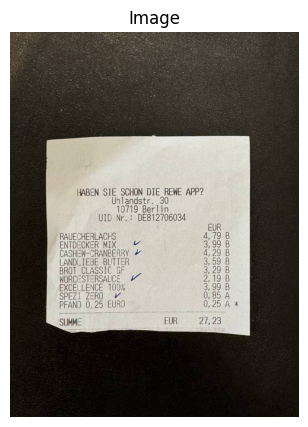

Tesseract extraction


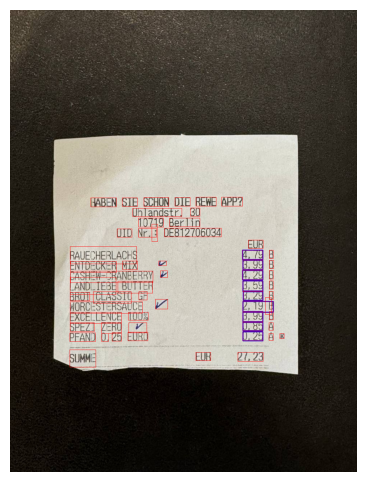

Item Count  Price            bbox price
0                      B         4.79  [643, 665, 699, 691]
1     ENTDECKER MIX 4  B         3.99  [644, 693, 699, 719]
2  CASHEW-CRANBERRY 4  B         4.29  [643, 721, 699, 747]
3              BUTTER  B         3.59  [644, 750, 699, 780]
4     BROT CLASSIC GF  B         3.29  [645, 778, 699, 804]
5      HORCESTERSAUCE 7°         2.19  [644, 807, 728, 837]
6     EXCELLENCE 100%  B         3.99  [644, 835, 699, 865]
7        SPEZI ZERO v  A         0.85  [644, 863, 699, 888]
8  PFAND 0, 25 EURD  A x         0.25  [644, 891, 699, 916]

Data successfully extracted

image 1/1 /kaggle/working/receipt.jpg: 640x480 4 checkmarks, 40.5ms
Speed: 5.2ms preprocess, 40.5ms inference, 293.7ms postprocess per image at shape (1, 3, 640, 480)
Detected checkmark: class=0, conf=0.84, bbox=(398, 797, 443, 835)
Detected checkmark: class=0, conf=0.80, bbox=(410, 721, 442, 745)
Detected checkmark: class=0, conf=0.71, bbox=(408, 688, 437, 712)
Detected checkmark: class=0, conf=0.59, bbox=(345, 865, 372, 888)


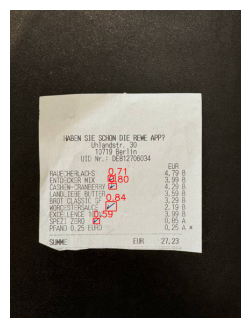

Item Count  Price            bbox price  is_marked
0                      B         4.79  [643, 665, 699, 691]      False
1     ENTDECKER MIX 4  B         3.99  [644, 693, 699, 719]       True
2  CASHEW-CRANBERRY 4  B         4.29  [643, 721, 699, 747]       True
3              BUTTER  B         3.59  [644, 750, 699, 780]      False
4     BROT CLASSIC GF  B         3.29  [645, 778, 699, 804]      False
5      HORCESTERSAUCE 7°         2.19  [644, 807, 728, 837]       True
6     EXCELLENCE 100%  B         3.99  [644, 835, 699, 865]      False
7        SPEZI ZERO v  A         0.85  [644, 863, 699, 888]       True
8  PFAND 0, 25 EURD  A x         0.25  [644, 891, 699, 916]      False

------------------------------
The result is Success
Real/Predicted final price: 15.91/15.91
------------------------------
Starting process for URL: https://drive.google.com/uc?export=download&id=1SrYa8wVoSA3aAKnirvV7qA6bnxiSSTRv, price_full: 6.15, price_final: 3.25 


Downloading...
From: https://drive.google.com/uc?export=download&id=1SrYa8wVoSA3aAKnirvV7qA6bnxiSSTRv
To: /kaggle/working/receipt.jpg
100%|██████████| 195k/195k [00:00<00:00, 77.8MB/s]


No resize needed
Image successfully loaded: receipt.jpg


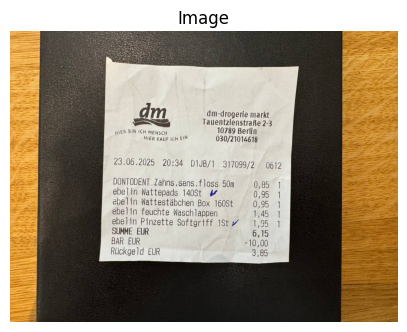

Tesseract extraction


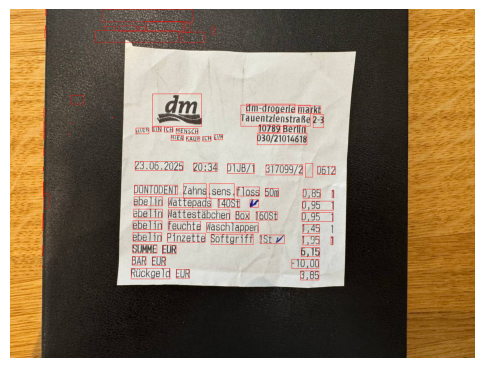

Result df is empty
Tesseract extraction failed, trying EasyOCR


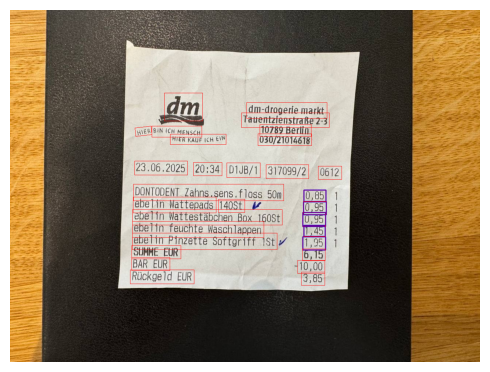

Item Count  Price            bbox price
0  dontodent  zahns . sens . f ioss  5om         0.85  [800, 492, 860, 524]
1                 ebelin wattepads 140st         0.95  [799, 523, 861, 559]
2         ebetin wattestäbchen box 16ost         0.95  [797, 553, 859, 591]
3            ebel in feuchte waschiappen         1.45  [800, 588, 858, 618]
4          ebelin pinzette softgriff ist         1.95  [797, 619, 859, 655]

EasyOCR extraction success: True
Data successfully extracted

image 1/1 /kaggle/working/receipt.jpg: 480x640 3 checkmarks, 37.3ms
Speed: 2.5ms preprocess, 37.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Detected checkmark: class=0, conf=0.68, bbox=(730, 617, 762, 648)
Detected checkmark: class=0, conf=0.56, bbox=(656, 519, 689, 550)
Detected checkmark: class=0, conf=0.28, bbox=(842, 430, 867, 455)


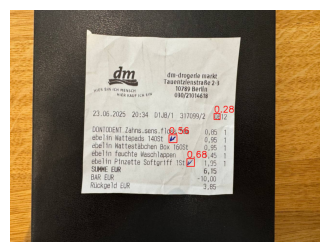

Item Count  Price            bbox price  \
0  dontodent  zahns . sens . f ioss  5om         0.85  [800, 492, 860, 524]   
1                 ebelin wattepads 140st         0.95  [799, 523, 861, 559]   
2         ebetin wattestäbchen box 16ost         0.95  [797, 553, 859, 591]   
3            ebel in feuchte waschiappen         1.45  [800, 588, 858, 618]   
4          ebelin pinzette softgriff ist         1.95  [797, 619, 859, 655]   

   is_marked  
0      False  
1       True  
2      False  
3      False  
4       True

------------------------------
The result is Success
Real/Predicted final price: 3.25/3.25
------------------------------
Starting process for URL: https://drive.google.com/uc?export=download&id=1T4TG7YtibpNR_rDWAv84-p4ZaT8M3gaI, price_full: 30.75, price_final: 21.78 


Downloading...
From: https://drive.google.com/uc?export=download&id=1T4TG7YtibpNR_rDWAv84-p4ZaT8M3gaI
To: /kaggle/working/receipt.jpg
100%|██████████| 181k/181k [00:00<00:00, 66.5MB/s]


No resize needed
Image successfully loaded: receipt.jpg


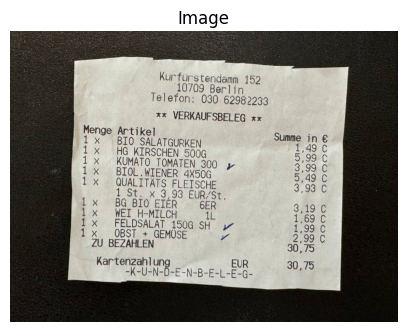

Tesseract extraction


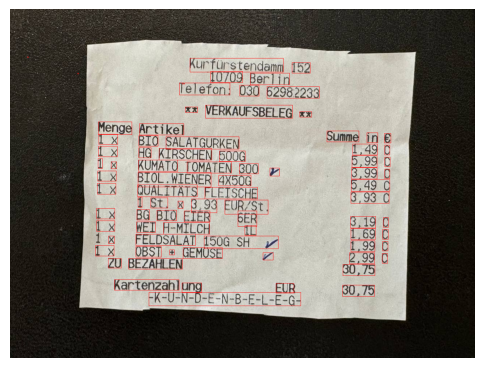

Result df is empty
Tesseract extraction failed, trying EasyOCR


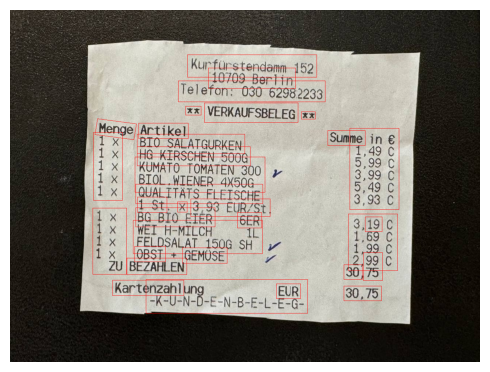

Result df is empty. EasyOCR extraction failed
Raw image use failed, trying preprcessed


Downloading...
From: https://drive.google.com/uc?export=download&id=1T4TG7YtibpNR_rDWAv84-p4ZaT8M3gaI
To: /kaggle/working/receipt.jpg
100%|██████████| 181k/181k [00:00<00:00, 71.2MB/s]

No resize needed
Image successfully loaded: receipt.jpg
image preprocessed: receipt.jpg


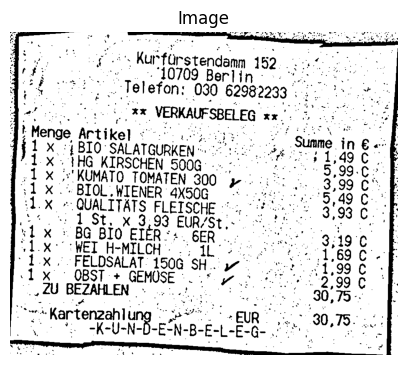

Tesseract extraction


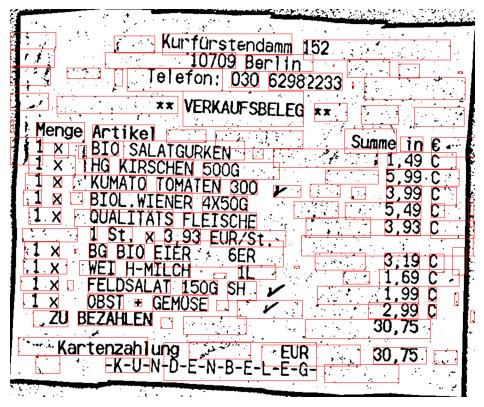

Result df is empty
Tesseract extraction failed, trying EasyOCR


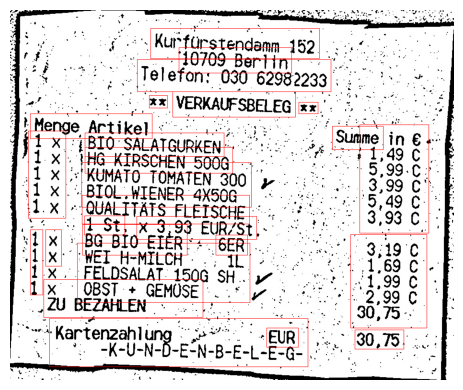

Result df is empty. EasyOCR extraction failed
Failed to extract data from receipt: https://drive.google.com/uc?export=download&id=1T4TG7YtibpNR_rDWAv84-p4ZaT8M3gaI
Starting process for URL: https://drive.google.com/uc?export=download&id=1Ke-JVBJa3vLSML6B3cF8qIPEUTO-JMES, price_full: 21.27, price_final: 20.23 


Downloading...
From: https://drive.google.com/uc?export=download&id=1Ke-JVBJa3vLSML6B3cF8qIPEUTO-JMES
To: /kaggle/working/receipt.jpg
100%|██████████| 174k/174k [00:00<00:00, 88.1MB/s]


No resize needed
Image successfully loaded: receipt.jpg


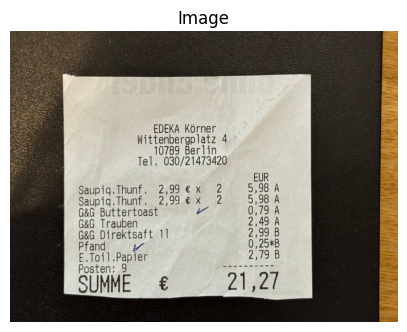

Tesseract extraction


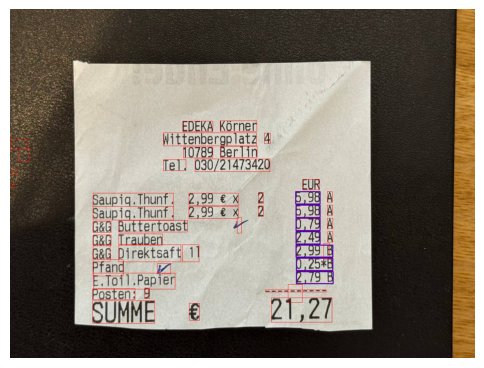

Item Count  Price            bbox price
0  Saupig.Thunf, 2,9€x 2  A         5.98  [786, 502, 853, 536]
1  Saupiq.Thunf. 2,9€x 2  A         5.98  [787, 539, 853, 573]
2     G8G Buttertoast or  A         0.79  [787, 575, 853, 609]
3            G8G Trauben  A         2.49  [787, 612, 853, 646]
4      G&G Direktsaft 1]  B         2.99  [787, 649, 888, 682]
5                        *B         0.25  [788, 685, 888, 719]
6           E.Toil.Papier B         2.79  [788, 722, 889, 755]

Data successfully extracted

image 1/1 /kaggle/working/receipt.jpg: 480x640 2 checkmarks, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
Detected checkmark: class=0, conf=0.75, bbox=(404, 694, 449, 733)
Detected checkmark: class=0, conf=0.68, bbox=(612, 574, 658, 613)


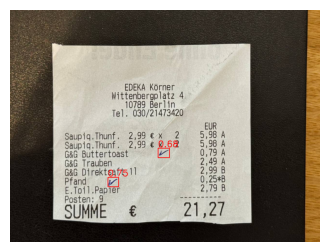

Item Count  Price            bbox price  is_marked
0  Saupig.Thunf, 2,9€x 2  A         5.98  [786, 502, 853, 536]      False
1  Saupiq.Thunf. 2,9€x 2  A         5.98  [787, 539, 853, 573]      False
2     G8G Buttertoast or  A         0.79  [787, 575, 853, 609]       True
3            G8G Trauben  A         2.49  [787, 612, 853, 646]      False
4      G&G Direktsaft 1]  B         2.99  [787, 649, 888, 682]      False
5                        *B         0.25  [788, 685, 888, 719]       True
6           E.Toil.Papier B         2.79  [788, 722, 889, 755]      False

------------------------------
The result is Success
Real/Predicted final price: 20.23/20.23
------------------------------
Starting process for URL: https://drive.google.com/uc?export=download&id=1TNbmYlscHjMb__C0XslWkynNc-CiJJPh, price_full: 10.28, price_final: 6.3 


Downloading...
From: https://drive.google.com/uc?export=download&id=1TNbmYlscHjMb__C0XslWkynNc-CiJJPh
To: /kaggle/working/receipt.jpg
100%|██████████| 169k/169k [00:00<00:00, 68.6MB/s]


No resize needed
Image successfully loaded: receipt.jpg


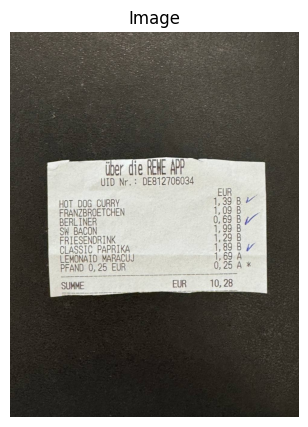

Tesseract extraction


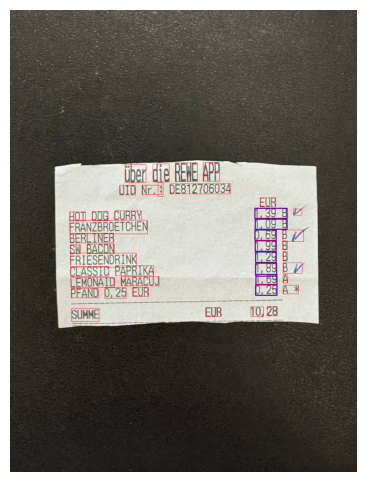

Item Count  Price            bbox price
0   HOT DOG CURRY 8 #7         1.39  [677, 549, 766, 577]
1    FRANZBROETCHEN 72         1.09  [678, 579, 766, 607]
2         BERLINER  By         0.89  [677, 609, 736, 638]
3          SW BACON  B         1.99  [678, 639, 736, 668]
4      FRIESENDRINK  B         1.29  [679, 670, 736, 699]
5  CLASSIC PAPRIKA  BY         1.89  [679, 701, 737, 737]
6  LEMONAID MARACUJ  A         1.69  [680, 732, 738, 760]
7     PFAND  EUR  AXx*         0.25  [679, 761, 738, 790]

Tesseract extraction failed, trying EasyOCR


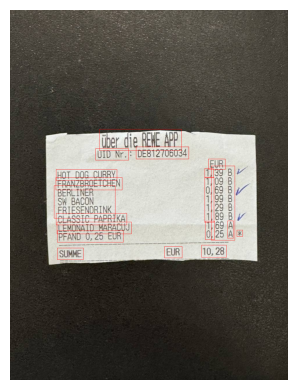

Result df is empty. EasyOCR extraction failed
Raw image use failed, trying preprcessed


Downloading...
From: https://drive.google.com/uc?export=download&id=1TNbmYlscHjMb__C0XslWkynNc-CiJJPh
To: /kaggle/working/receipt.jpg
100%|██████████| 169k/169k [00:00<00:00, 65.9MB/s]

No resize needed
Image successfully loaded: receipt.jpg
image preprocessed: receipt.jpg


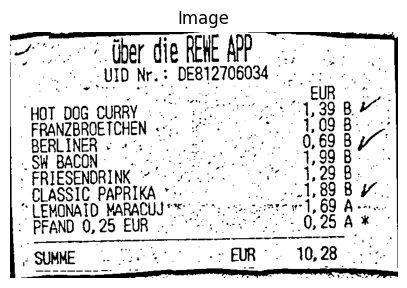

Tesseract extraction


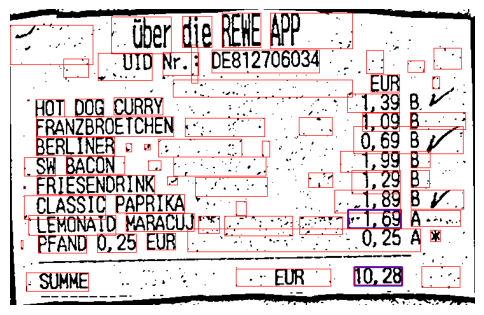

Item Count  Price            bbox price
0             Arne         1.89  [531, 315, 614, 344]
1  SOME ER.  .:°5-        10.28  [541, 405, 616, 434]

Tesseract extraction failed, trying EasyOCR


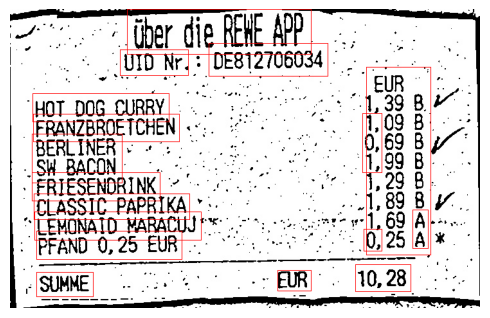

Result df is empty. EasyOCR extraction failed
Failed to extract data from receipt: https://drive.google.com/uc?export=download&id=1TNbmYlscHjMb__C0XslWkynNc-CiJJPh


In [10]:
for download_url, price_full, price_final in medium_checks:
    print(f'Starting process for URL: {download_url}, price_full: {price_full}, price_final: {price_final} ')
    process_receipt(download_url, price_full, price_final, True)